<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Automating the art of data augmentation</div>

In [1]:
# TODO : commenter tout le code et retirer les commentaires ChatGPT
# TODO : coder display_one_image_per_class()
# TODO : citer les articles à chaque introduction d'une nouvelle méthode
# TODO : enlever le warning de la fonction plot_before_after_augmentation

This notebook aims at providing an overview of existing methods for automating the process of data augmentation.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fga-0/automating_data_augmentation/blob/main/Automating_the_art_of_data_augmentation.ipynb)

Expliquer comment utiliser les GPU Google disponibles pour exécuter le notebook :

    - "options de connexion supplémentaires"
    - "Modifier le type d'exécution"
    - GPU

Ajouter une image en début de notebook pour donner envie de l'exécuter -> GIF hamster/quokka

# What is data augmentation

!! Lire des blog post pour une intro plus attrayante !!

Modern machine learning models, such as deep neural networks, may have billions of parameters and **require massive labeled training datasets** which might be unavailable. The technique of artificially expanding labeled training datasets, known as *data augmentation*, has quickly become critical for combating this data scarcity problem.

Data augmentation has several advantages :
1. It enhances the generalization capacity of the model by reducing the risk of overfitting. As the training set gets larger, the model learns on a more diversified data.
2. It grows the training set for a very low cost. No additional sampling campaign is required.

Methods have emerged to automate the augmentation process. This notebook will go through a variety of methods, highlighting the pros and cons of using each of them.

In this notebook, we will focus on image classification tasks as they represent the main application of data augmentation. In image classification, data augmentation has become a standard practice.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.optim as optim

## 🧪Transformation lab 

Welcome to the transformation lab, here you are able to manipulate transformation as you wish and observe their impact on the data.

### Load CIFAR10 data

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The 10 classes are :
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

In [34]:
path_to_data = "./cifar10"

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# path_to_data = "drive/MyDrive/SDD/data_augmentation/cifar10"

Mounted at /content/drive


In [35]:
# Define transformations (normalization, conversion to tensor)
default_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

# Load full CIFAR-10 dataset
lab_dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=default_transform)

Files already downloaded and verified


In [36]:
image_width = lab_dataset[0][0].shape[1]
print(f"The dataset is made of {image_width}x{image_width} pixels images.")

The dataset is made of 224x224 pixels images.


A few transformations :

In [37]:
transformations = [
    transforms.CenterCrop(size=image_width/2),
    transforms.RandomCrop(size=16),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomAffine(degrees=45, translate=(0.2, 0.2), shear=15),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomInvert(p=0.5),
    transforms.RandomSolarize(-0.1, p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5)
]

Choose a transformation and visualize its effect on 5 images sampled from the dataset.

In [38]:
import utils
import importlib
importlib.reload(utils)

<module 'utils' from '/home/flo/SDD/automating_data_augmentation/utils.py'>

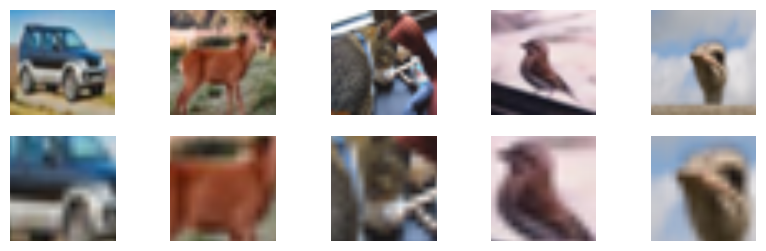

In [41]:
utils.plot_before_after_augmentation(dataset=lab_dataset, transformation=transformations[0])

## Image classification

Now, let us reload the data to perform an image classification task. 

In [42]:
# Define transformations (normalization, conversion to tensor)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    # transforms.Normalize((0.5,), (0.5,))
])

# Load full CIFAR-10 dataset
# # Les images CIFAR10 sont de dimension 32x32.
trainset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=path_to_data, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [43]:
train_subset, test_subset = utils.get_subset(trainset=trainset, testset=testset, percentage=0.02)


Training samples: 1000
Test samples: 200


## Let's train a CNN : WideResNet

Now that the data is loaded, we can train a Convolutional Neural Network on this data to assess its performance before applying any augmentation. WideResNet will be used as it is a commonly used network for bench-marking classification task on image data.

In [ ]:
from utils import get_trainloader_valloader

In [ ]:
train_loader, val_loader = get_trainloader_valloader(dataset=train_subset,
                                                     split=0.8,
                                                     batch_size=32
                                                     )
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

In [ ]:
from torchvision.models import wide_resnet50_2

# Load Wide ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# wrn = wide_resnet50_2(num_classes=10)  # CIFAR-10 has 10 classes

# Load a pre-trained Wide ResNet-50-2 model:
wrn = wide_resnet50_2(pretrained=True)
# Freeze all model parameters except for the final layer:
for param in wrn.parameters():
    param.requires_grad = False
# Get the number of input features for the original last layer:
num_feature = wrn.fc.in_features
# Replace the final classification layer to match your dataset:
wrn.fc = nn.Linear(num_feature, 10)
# View the structure of the new final layer (optional):
print(wrn.fc)
# Move the model to the GPU for accelerated training:
wrn = wrn.to(device)

print(f"Using device: {device}")

/home/flo/miniconda3/envs/data_augmentation_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/flo/miniconda3/envs/data_augmentation_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=10, bias=True)
Using device: cpu


Let's evaluate the pretrained model on the testset.

In [53]:
loaded_model = wide_resnet50_2()
# Freeze all model parameters except for the final layer:
for param in loaded_model.parameters():
    param.requires_grad = False
# Get the number of input features for the original last layer:
num_feature = loaded_model.fc.in_features
# Replace the final classification layer to match your dataset:
loaded_model.fc = nn.Linear(num_feature, 10)
# View the structure of the new final layer (optional):
print(loaded_model.fc)
# Move the model to the GPU for accelerated training:
loaded_model = loaded_model.to(device)
loaded_model.load_state_dict(torch.load("./wrn_trained_on_subset_of_raw_data", weights_only=False, map_location=torch.device('cpu')))

Linear(in_features=2048, out_features=10, bias=True)


<All keys matched successfully>

In [54]:
utils.evaluate(wrn, test_loader, device)

Accuracy: 65.00%
Taux d'erreur: 35.00%


(0.65, 0.35)

The pretrained model gets a poor accuracy on the testset. It needs to be trained on the CIFAR10 data !

In [ ]:
criterion = nn.CrossEntropyLoss()
patience = 5
min_delta_loss = 0.001
min_delta_accuracy = 0.1

In [48]:
optimizer = optim.Adam(wrn.fc.parameters(), lr=0.001)
# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
wrn_trained = utils.train_WideResNet(model=wrn, trainloader=train_loader, valloader=val_loader, num_epochs=3, 
                                     batch_size=32, optimizer=optimizer, criterion=criterion, device=device, scheduler=scheduler,
                                     patience=patience, min_delta_loss=min_delta_loss, min_delta_accuracy=min_delta_accuracy)

Epoch 1/3:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1: Loss=2.0071, Accuracy=29.30%


KeyboardInterrupt: 

In [14]:
utils.evaluate(wrn_trained, test_loader, device)

Accuracy: 69.00%
Taux d'erreur: 31.00%


(0.69, 0.31000000000000005)

On note que la généralisation se passe mal, on pert 10% d'accuracy en évaluant le modèle sur le testset.

## About the importance of learning good data augmentation policies

### Label-invariant and label-mixing transformations

Ajouter définitions et exemples.

### Bad augmentation policies

Before diving into the art of data augmentation, let us raise awareness on the potential issues triggered by bad augmentation policies.

- "Label-variant" transformations

    Unfortunately, when applying augmentations on a dataset, one might introduce bad-labelled data. In fact, the goal of label-invariant augmentations is to enrich the dataset by appllying transformation without altering the labels. The example below illustrates how unconvenient such unwanted augmentation can be.

Some datasets benefited from good data augmentation policies found empirically. However, such policies are rarely transferable to other datasets. For example, horizontal flipping of images during training is an effective data augmentation method on CIFAR-10, but not on MNIST, due to the different symmetries present in these datasets.

<center><img src="https://github.com/fga-0/automating_data_augmentation/blob/main/img/bad_augmentation_mnist.jpg?raw=1" height="55%" width="55%"></img></center>

# Methods to automate data augnentation

Augmentation as a search problem : some transformations might not help or worse deteriorate the dataset as we have seen. 

Besides, with composition, the search space grows quadratically so a brute-force search is not feasible. 

# AutoAugment

In [15]:
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

In [16]:
transform_augment = transforms.Compose([
    transforms.Resize(224),
    AutoAugment(AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset_aug = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=transform_augment)

Files already downloaded and verified


In [17]:
len(trainset_aug)

50000

In [18]:
def plot_images(dataset,
                n_images
                ) :
    size = n_images
    image_idx = np.random.randint(low=0, high=len(dataset), size=size)
    fig, ax = plt.subplots(nrows=1, ncols=size, figsize=(10, 3))
    for i in range(size) :
        idx = image_idx[i]
        raw_image = dataset[idx][0]
        ax[i].imshow(np.transpose(raw_image, (1,2,0)))
        ax[i].axis("off")
    plt.show()

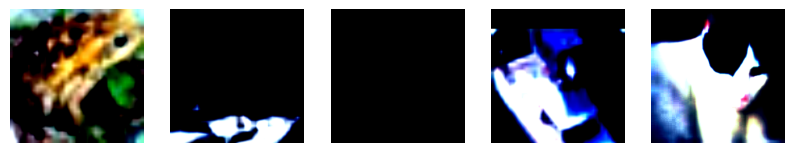

In [19]:
plot_images(trainset_aug, 5)

In [20]:
train_subset_aug, test_subset_aug = utils.get_subset(trainset=trainset_aug, testset=testset, percentage=0.02)

Training samples: 1000
Test samples: 200


In [ ]:
# Split the training dataset into training and validation sets
train_loader_aug, val_loader_aug = get_trainloader_valloader(dataset=train_subset_aug,
                                                             split=0.8,
                                                             batch_size=32)
test_loader_aug = DataLoader(test_subset_aug, batch_size=32, shuffle=False)

Let us reload the WideResNet pretrained network.

In [22]:
from torchvision.models import wide_resnet50_2

# Load Wide ResNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# wrn = wide_resnet50_2(num_classes=10)  # CIFAR-10 has 10 classes

# Load a pre-trained Wide ResNet-50-2 model:
wrn = wide_resnet50_2(pretrained=True)
# Freeze all model parameters except for the final layer:
for param in wrn.parameters():
    param.requires_grad = False
# Get the number of input features for the original last layer:
num_feature = wrn.fc.in_features
# Replace the final classification layer to match your dataset:
wrn.fc = nn.Linear(num_feature, 10)
# View the structure of the new final layer (optional):
print(wrn.fc)
# Move the model to the GPU for accelerated training:
wrn = wrn.to(device)

print(f"Using device: {device}")

Linear(in_features=2048, out_features=10, bias=True)
Using device: cuda


In [23]:
optimizer = optim.Adam(wrn.fc.parameters(), lr=0.001)
# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
wrn_trained_on_augmented_data = utils.train_WideResNet(model=wrn, trainloader=train_loader, num_epochs=5, 
                                                       batch_size=32, optimizer=optimizer, criterion=criterion, 
                                                       device=device, scheduler=scheduler, patience=patience, 
                                                       min_delta_loss=min_delta_loss, min_delta_accuracy=min_delta_accuracy)

Epoch 1: Loss=1.9124, Accuracy=35.80%


Epoch 2: Loss=1.2958, Accuracy=62.70%


Epoch 3: Loss=1.0557, Accuracy=68.40%


Epoch 4: Loss=0.8857, Accuracy=73.50%


Epoch 5: Loss=0.7740, Accuracy=80.10%
Training complete!


In [25]:
utils.evaluate(wrn_trained_on_augmented_data, test_loader, device)

Accuracy: 73.00%
Taux d'erreur: 27.00%


(0.73, 0.27)

Now let's concatenate the raw subset and the augmented subset in order to train the WideResNet with augmented data.

In [26]:
from torch.utils.data import ConcatDataset

In [ ]:
train_subset_raw_and_AA = ConcatDataset([train_subset, train_subset_aug])

train_loader_raw_and_AA, val_loader_raw_and_AA = get_trainloader_valloader(dataset=train_subset_raw_and_AA, 
                                                                           split=0.8,
                                                                           batch_size=32) 
test_loader_raw_and_AA = DataLoader(test_subset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
len(train_subset_raw_and_AA)

2000

Let us reload the WideResNet pretrained network.

In [ ]:
# !pip install torchviz

In [ ]:
# from torchviz import make_dot

# # Generate dummy input
# x = torch.randn(1, 3, 224, 224).to(device)

# # Forward pass
# y = wrn(x)

# # Create a visualization
# make_dot(y, params=dict(wrn.named_parameters())).render("wrn_architecture", format="png")

'wrn_architecture.png'

In [ ]:
# !pip install torchinfo

In [ ]:
# from torchinfo import summary

In [ ]:
# Display the architecture summary
# summary(wrn, input_size=(1, 3, 224, 224))  # (batch_size, channels, height, width)

In [ ]:
# print(wrn)

In [29]:
# # Load a pre-trained Wide ResNet-50-2 model:
wrn = wide_resnet50_2(pretrained=True)
# Freeze all model parameters except for the final layer:
for param in wrn.parameters():
    param.requires_grad = False
# Get the number of input features for the original last layer:
num_feature = wrn.fc.in_features
# Replace the final classification layer to match your dataset:
wrn.fc = nn.Linear(num_feature, 10)
# View the structure of the new final layer (optional):
print(wrn.fc)
# Move the model to the GPU for accelerated training:
wrn = wrn.to(device)

Linear(in_features=2048, out_features=10, bias=True)


In [30]:
optimizer = optim.Adam(wrn.fc.parameters(), lr=0.001)
# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
wrn_trained_on_raw_AND_augmented_data = utils.train_WideResNet(model=wrn, trainloader=train_loader_raw_and_AA, num_epochs=5, batch_size=32, 
                                                               optimizer=optimizer, criterion=criterion, device=device, scheduler=scheduler,
                                                               valloader=val_loader_raw_and_AA, patience=patience, 
                                                               min_delta_loss=min_delta_loss, min_delta_accuracy=min_delta_accuracy)

Epoch 1: Loss=1.7880, Accuracy=40.40%


Epoch 2: Loss=1.2292, Accuracy=61.40%


Epoch 3: Loss=1.1016, Accuracy=63.40%


Epoch 4: Loss=0.9978, Accuracy=69.30%


Epoch 5: Loss=0.9154, Accuracy=71.45%
Training complete!


In [32]:
utils.evaluate(wrn_trained_on_raw_AND_augmented_data, test_loader, device)

Accuracy: 75.50%
Taux d'erreur: 24.50%


(0.755, 0.245)

# RandAugment

In [ ]:
from torchvision.transforms import RandAugment

# Définition des transformations avec RandAugment
transform_randaugment = transforms.Compose([
    transforms.Resize(224),
    RandAugment(num_ops=2, magnitude=9),  # num_ops définit le nombre d'opérations aléatoires, magnitude leur intensité
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Chargement du dataset avec augmentation
trainset_randaugment = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=transform_randaugment)

In [ ]:
train_subset_randaugment, test_subset_randaugment = utils.get_subset(trainset=trainset_randaugment, testset=testset, percentage=0.02)


In [ ]:
train_subset_raw_and_randaugment = ConcatDataset([train_subset, train_subset_randaugment])

In [ ]:
train_loader_raw_and_randaugment, val_loader_raw_and_randaugment = get_trainloader_valloader(dataset=train_subset_raw_and_randaugment,
                                                                                             split=0.8,
                                                                                             batch_size=32)
test_loader_raw_and_randaugment = DataLoader(test_subset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
# Load Wide ResNet model
# Load a pre-trained Wide ResNet-50-2 model:
wrn = wide_resnet50_2(pretrained=True)
# Freeze all model parameters except for the final layer:
for param in wrn.parameters():
    param.requires_grad = False
# Get the number of input features for the original last layer:
num_feature = wrn.fc.in_features
# Replace the final classification layer to match your dataset:
wrn.fc = nn.Linear(num_feature, 10)
# View the structure of the new final layer (optional):
print(wrn.fc)
# Move the model to the GPU for accelerated training:
wrn = wrn.to(device)

print(f"Using device: {device}")

In [ ]:
optimizer = optim.Adam(wrn.fc.parameters(), lr=0.001)
# Learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
wrn_trained_on_randaugment_data = utils.train_WideResNet(model=wrn, trainloader=train_loader_raw_and_randaugment, valloader=val_loader_raw_and_randaugment, num_epochs=5, 
                                                         batch_size=32, optimizer=optimizer, criterion=criterion, device=device, scheduler=scheduler,
                                                         patience=patience, min_delta_loss=min_delta_loss, min_delta_accuracy=min_delta_accuracy)

In [ ]:
utils.evaluate(wrn_trained_on_randaugment_data, test_loader, device)

## Fast-AutoAugment : Bayesian optimization

## Adversarial AutoAugment

Achieves state-of-the-art performance.

## Examples of data augmentation

Heuristic data augmentation schemes often rely on the composition of a set of simple transformation functions (TFs) such as rotations and flips (see Figure 1). When chosen carefully, data augmentation schemes tuned by human experts can improve model performance. However, such heuristic strategies in practice can cause large variances in end model performance, and may not produce augmentations needed for state-of-the-art models.

### Augmented data VS synthetic data

Décrire la différence entre les deux et donner les enjeux de confidentialités liés aux données synthétiques.

### Available transformations

### Linear transformations

In [ ]:
from autoaugment import augmentation_transforms as at

In [ ]:
train_iter = iter(train_loader)
images, labels = next(train_iter)
image = images[0]
label = labels[0]

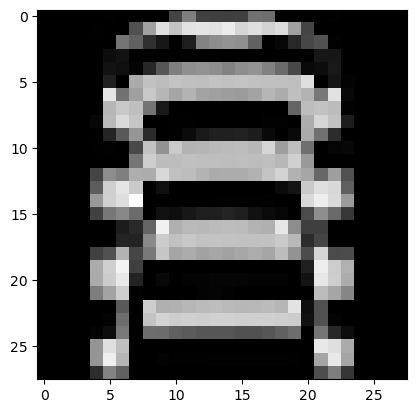

In [ ]:
plt.imshow(image.squeeze(), cmap='gray')

In [ ]:
aug_img = at.zero_pad_and_crop(image)

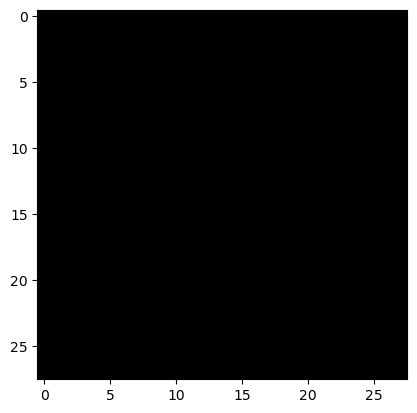

In [ ]:
plt.imshow(aug_img.squeeze(), cmap='gray')

In [ ]:
at.flip_lr(image)

TypeError: 'TransformT' object is not callable

In [ ]:
image.shape

torch.Size([1, 28, 28])

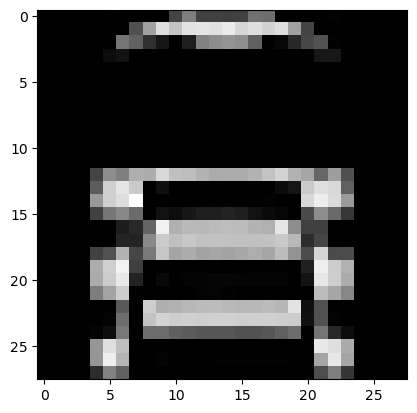

In [ ]:
plt.imshow(at.cutout_numpy(image, size=8).squeeze(), cmap='gray')

### Performance of models trained with augmented data

## Theory

Before diving into the art of automating data augmentation, let's take a step back and try to understand the theoretical aspects of this process.

- How to get a theoretical understanding of data augmentation ?
- How to automate data augmentation ?

### Data augmentation as a kernel

### Data Augmentation Under A Simplified Linear Setting

## Practical Methods of Learnable Data Augmentations

### Tanda

<div class="alert alert-danger">
    <summary markdown="span"><b>Le repo Tanda ne fonctionne qu'avec Tensorflow 1.2 !!</b></summary>
</div>

<!-- ![image.png](attachment:image.png) -->
<center><img src="https://github.com/fga-0/automating_data_augmentation/blob/main/img/tanda_archi.png?raw=1" height="55%" width="55%"></img></center>


"""

TANDA: Transformation Adversarial Networks for Data Augmentations
To address this problem, TANDA (
Ratner et al. 2017
) proposes a framework to learn augmentations, whichmodels data augmentations as sequences of Transformation Functions (TFs) provided by users. For example,these might include
“rotate 5 degrees”
or
“shift by 2 pixels”
. At the core, this framework consists of twocomponents (1)
learning a TF sequence generator
that results in useful augmented data points, and (2)
usingthe sequence generator
to augment training sets for a downstream model. In particular, the TF sequencegenerator is trained to produce realistic images by having to fool a discriminator network, following the GANsframework (
Goodfellow et al. 2014
). The underlying assumption here is that the transformations would eitherlead to realistic images, or indistinguishable garbage images that are off the manifold. As shown in Figure 1,the objective for the generator is to produce sequences of TFs such that the augmented data point can fool thediscriminator; whereas the objective for the discriminator is to produce values close to 1 for data points in theoriginal training set and values close to 0 for augmented data points.

"""

### AutoAugment

AutoAugment aims to automate the process of finding an effective data augmentation policy for a target dataset.

AutoAugment has 2 use cases :
1) AutoAugment can be applied directly on the dataset of interest to find the best augmentation policy (AutoAugment-direct)

2) learned policies can be transferred to new datasets (AutoAugment-transfer)

In [ ]:
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

In [ ]:
# Appliquer AutoAugment à Fashion-MNIST
transform_augment = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.CIFAR10),  # Utilisation de la politique d'augmentation
    transforms.ToTensor()
])

# Charger Fashion-MNIST avec augmentation
train_set_aug = torchvision.datasets.FashionMNIST(root='./fashion_mnist', train=True, download=True, transform=transform_augment)
train_loader_aug = torch.utils.data.DataLoader(train_set_aug, batch_size=64, shuffle=True)

The data went through the augmentation process.

In [ ]:
len(train_set_aug)

60000

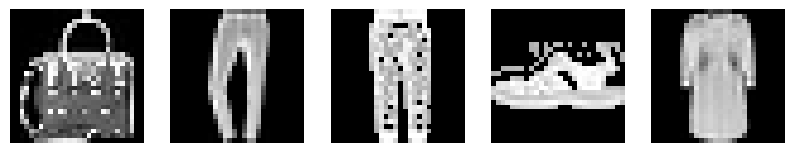

In [ ]:
# Visualiser des images après augmentation
utils.show_images(train_set_aug)

In [ ]:
# Initialiser un nouveau modèle (identique)
model_aug = SimpleCNN().to(device)
optimizer_aug = optim.Adam(model_aug.parameters(), lr=0.001)

# Entraîner avec AutoAugment
train_model(model_aug, train_loader_aug, test_loader, device=device, optimizer=optimizer, criterion=criterion, epochs=10)

 10%|█         | 1/10 [00:38<05:48, 38.76s/it]

Epoch 1/10 - Loss: 2161.6639 - Acc: 0.1000


 20%|██        | 2/10 [01:21<05:27, 40.88s/it]

Epoch 2/10 - Loss: 2161.6932 - Acc: 0.0999


 30%|███       | 3/10 [01:59<04:38, 39.85s/it]

Epoch 3/10 - Loss: 2161.6196 - Acc: 0.1000


 40%|████      | 4/10 [02:37<03:55, 39.19s/it]

Epoch 4/10 - Loss: 2161.5680 - Acc: 0.0998


 50%|█████     | 5/10 [03:17<03:15, 39.18s/it]

Epoch 5/10 - Loss: 2161.5872 - Acc: 0.0999


 60%|██████    | 6/10 [03:55<02:35, 38.97s/it]

Epoch 6/10 - Loss: 2161.5827 - Acc: 0.1001


 70%|███████   | 7/10 [04:34<01:56, 38.86s/it]

Epoch 7/10 - Loss: 2161.6371 - Acc: 0.0999


 80%|████████  | 8/10 [05:12<01:17, 38.79s/it]

Epoch 8/10 - Loss: 2161.5954 - Acc: 0.0997


 90%|█████████ | 9/10 [05:51<00:38, 38.65s/it]

Epoch 9/10 - Loss: 2161.6579 - Acc: 0.0999


100%|██████████| 10/10 [06:30<00:00, 39.01s/it]

Epoch 10/10 - Loss: 2161.6742 - Acc: 0.1003


Let's see how the model generalizes.

In [ ]:
test_iter = iter(test_loader)
images, labels = next(test_iter)
image = images[0]
label = labels[0]

(-0.5, 27.5, 27.5, -0.5)

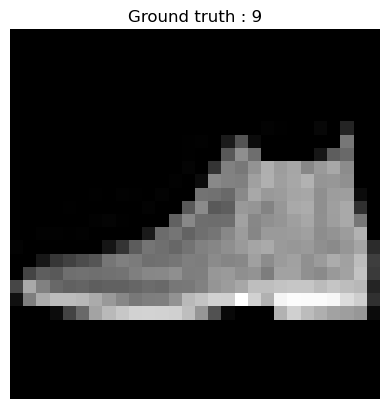

In [ ]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Ground truth : {label.item()}")
plt.axis("off")

In [ ]:
model_aug.eval()
with torch.no_grad():
    image = image.unsqueeze(0)
    output = model_aug(image)
    print(output)
    _, predicted = torch.max(output, 1)
print(f"Model prediction : {predicted.item()}")

tensor([[ 0.0051, -0.0624,  0.0657, -0.0576, -0.0370,  0.0389, -0.0679, -0.0463,
          0.0130, -0.0720]])
Model prediction : 2


### Adversarial autoAugment

### RandAugment